# NB 06: Function Prediction for Unannotated Genes

Predict function for poorly annotated genes ("hypothetical protein", etc.)
using module and module-family context.

Prediction sources:
- **Module-based**: function from module's top enrichment label
- **Family-based**: if module belongs to a conserved family, use family consensus

Confidence score = |gene_weight| × enrichment_significance × cross-organism_consistency

**Run locally** — no Spark needed.

In [1]:
import pandas as pd
import numpy as np
from pathlib import Path

DATA_DIR = Path('../data')
MODULE_DIR = DATA_DIR / 'modules'
ANNOT_DIR = DATA_DIR / 'annotations'
FAMILY_DIR = DATA_DIR / 'module_families'
PRED_DIR = DATA_DIR / 'predictions'
PRED_DIR.mkdir(parents=True, exist_ok=True)

pilots = pd.read_csv(DATA_DIR / 'pilot_organisms.csv')
pilot_ids = pilots['orgId'].tolist()
print(f"Pilot organisms: {pilot_ids}")

Pilot organisms: ['DvH', 'Btheta', 'Methanococcus_S2', 'psRCH2', 'Putida', 'Phaeo', 'Marino', 'pseudo3_N2E3', 'Koxy', 'Cola', 'WCS417', 'Caulo', 'SB2B', 'pseudo6_N2E2', 'Dino', 'pseudo5_N2C3_1', 'Miya', 'Pedo557', 'MR1', 'Keio', 'Korea', 'PV4', 'pseudo1_N1B4', 'acidovorax_3H11', 'SynE', 'Methanococcus_JJ', 'BFirm', 'Kang', 'ANA3', 'Cup4G11', 'pseudo13_GW456_L13', 'Ponti']


In [2]:
# Load module families and family annotations
families = pd.read_csv(FAMILY_DIR / 'module_families.csv')
fam_ann = pd.read_csv(FAMILY_DIR / 'family_annotations.csv')
print(f"Module families: {families['familyId'].nunique()}")
print(f"Annotated families: {(fam_ann['consensus_term'] != 'unannotated').sum()}")

Module families: 749
Annotated families: 32


## 1. Identify Unannotated Genes

In [3]:
unannotated_patterns = ['hypothetical', 'uncharacterized', 'unknown function',
                        'DUF', 'predicted protein', 'putative']

all_predictions = []

for org_id in pilot_ids:
    out_file = PRED_DIR / f'{org_id}_predictions.csv'
    if out_file.exists() and out_file.stat().st_size > 0:
        print(f"CACHED: {org_id}")
        preds = pd.read_csv(out_file)
        all_predictions.append(preds)
        continue
    
    print(f"\nPredicting for {org_id}...")
    
    # Load gene metadata
    genes = pd.read_csv(ANNOT_DIR / f'{org_id}_genes.csv')
    genes['locusId'] = genes['locusId'].astype(str)
    
    # Identify unannotated genes
    def is_unannotated(desc):
        if pd.isna(desc) or desc.strip() == '':
            return True
        desc_lower = desc.lower()
        return any(p in desc_lower for p in unannotated_patterns)
    
    genes['is_unannotated'] = genes['desc'].apply(is_unannotated)
    unannotated = genes[genes['is_unannotated']]
    print(f"  Unannotated genes: {len(unannotated)} / {len(genes)} ({len(unannotated)/len(genes)*100:.1f}%)")
    
    # Load module data
    weights = pd.read_csv(MODULE_DIR / f'{org_id}_gene_weights.csv', index_col=0)
    weights.index = weights.index.astype(str)
    membership = pd.read_csv(MODULE_DIR / f'{org_id}_gene_membership.csv', index_col=0)
    membership.index = membership.index.astype(str)
    
    # Load module annotations (skip if empty/missing)
    ann_file = MODULE_DIR / f'{org_id}_module_annotations.csv'
    if not ann_file.exists() or ann_file.stat().st_size < 10:
        print(f"  No module annotations — skipping")
        continue
    ann = pd.read_csv(ann_file)
    if len(ann) == 0:
        print(f"  Empty annotations — skipping")
        continue
    
    # Get top annotation per module
    sig_ann = ann[ann['significant']].sort_values('fdr')
    top_ann = sig_ann.groupby('module').first().reset_index()
    mod_to_ann = dict(zip(top_ann['module'], top_ann['term']))
    mod_to_fdr = dict(zip(top_ann['module'], top_ann['fdr']))
    mod_to_db = dict(zip(top_ann['module'], top_ann['database']))
    
    # Get family info for this organism's modules
    org_families = families[families['orgId'] == org_id]
    mod_to_family = dict(zip(org_families['module'], org_families['familyId']))
    fam_to_ann = dict(zip(fam_ann['familyId'], fam_ann['consensus_term']))
    fam_to_norgs = dict(zip(fam_ann['familyId'], fam_ann['n_organisms']))
    
    # Generate predictions
    preds = []
    for _, gene_row in unannotated.iterrows():
        locus = str(gene_row['locusId'])
        if locus not in membership.index:
            continue
        
        # Find modules this gene belongs to
        gene_modules = membership.columns[membership.loc[locus] == 1].tolist()
        if not gene_modules:
            continue
        
        for mod in gene_modules:
            gene_weight = abs(weights.loc[locus, mod])
            
            # Module-based prediction
            mod_term = mod_to_ann.get(mod)
            if not mod_term:
                continue
            
            mod_fdr = mod_to_fdr.get(mod, 1.0)
            mod_db = mod_to_db.get(mod, '')
            
            # Family-based prediction
            fam_id = mod_to_family.get(mod)
            fam_term = fam_to_ann.get(fam_id) if fam_id else None
            fam_n_orgs = fam_to_norgs.get(fam_id, 0) if fam_id else 0
            
            # Confidence score
            fdr_score = max(0, -np.log10(max(mod_fdr, 1e-300)))  # higher = better
            cross_org_bonus = fam_n_orgs / len(pilot_ids) if fam_n_orgs > 1 else 0
            confidence = gene_weight * fdr_score * (1 + cross_org_bonus)
            
            # Use family annotation if available and different
            if fam_term and fam_term != 'unannotated':
                prediction_source = 'family'
                predicted_function = fam_term
            else:
                prediction_source = 'module'
                predicted_function = mod_term
            
            preds.append({
                'orgId': org_id,
                'locusId': locus,
                'sysName': gene_row.get('sysName', ''),
                'original_desc': gene_row['desc'],
                'module': mod,
                'gene_weight': gene_weight,
                'predicted_function': predicted_function,
                'prediction_source': prediction_source,
                'annotation_db': mod_db,
                'enrichment_fdr': mod_fdr,
                'familyId': fam_id if fam_id else '',
                'family_n_organisms': fam_n_orgs,
                'confidence': confidence
            })
    
    preds_df = pd.DataFrame(preds)
    if len(preds_df) > 0:
        # Keep best prediction per gene (highest confidence)
        preds_df = preds_df.sort_values('confidence', ascending=False)
        preds_df = preds_df.drop_duplicates('locusId', keep='first')
        preds_df.to_csv(out_file, index=False)
        all_predictions.append(preds_df)
        print(f"  Predictions: {len(preds_df)} genes")
        print(f"  Family-backed: {(preds_df['prediction_source'] == 'family').sum()}")
        print(f"  Module-only: {(preds_df['prediction_source'] == 'module').sum()}")
    else:
        print(f"  No predictions generated")

CACHED: DvH
CACHED: Btheta

Predicting for Methanococcus_S2...
  Unannotated genes: 272 / 1793 (15.2%)
  No module annotations — skipping
CACHED: psRCH2
CACHED: Putida
CACHED: Phaeo
CACHED: Marino
CACHED: pseudo3_N2E3
CACHED: Koxy
CACHED: Cola
CACHED: WCS417

Predicting for Caulo...
  Unannotated genes: 818 / 3943 (20.7%)
  No module annotations — skipping
CACHED: SB2B
CACHED: pseudo6_N2E2
CACHED: Dino
CACHED: pseudo5_N2C3_1
CACHED: Miya
CACHED: Pedo557
CACHED: MR1
CACHED: Keio

Predicting for Korea...
  Unannotated genes: 1100 / 4245 (25.9%)
  No module annotations — skipping
CACHED: PV4
CACHED: pseudo1_N1B4
CACHED: acidovorax_3H11
CACHED: SynE
CACHED: Methanococcus_JJ
CACHED: BFirm
CACHED: Kang
CACHED: ANA3
CACHED: Cup4G11
CACHED: pseudo13_GW456_L13
CACHED: Ponti


## 2. Combined Summary

In [4]:
if all_predictions:
    combined = pd.concat(all_predictions, ignore_index=True)
    combined.to_csv(PRED_DIR / 'all_predictions_summary.csv', index=False)
    
    print("="*60)
    print("PREDICTION SUMMARY")
    print("="*60)
    print(f"Total predictions: {len(combined)}")
    print(f"\nBy organism:")
    for org_id in pilot_ids:
        org_preds = combined[combined['orgId'] == org_id]
        if len(org_preds) > 0:
            print(f"  {org_id}: {len(org_preds)} predictions, "
                  f"median confidence={org_preds['confidence'].median():.2f}")
    
    print(f"\nBy source:")
    print(combined['prediction_source'].value_counts().to_string())
    
    print(f"\nConfidence distribution:")
    print(combined['confidence'].describe().to_string())
    
    print(f"\nTop 10 highest-confidence predictions:")
    top10 = combined.nlargest(10, 'confidence')
    print(top10[['orgId', 'locusId', 'predicted_function', 'confidence',
                 'prediction_source']].to_string(index=False))
else:
    print("No predictions generated.")

PREDICTION SUMMARY
Total predictions: 878

By organism:
  DvH: 36 predictions, median confidence=4.11
  Btheta: 30 predictions, median confidence=1.26
  psRCH2: 11 predictions, median confidence=1.50
  Putida: 39 predictions, median confidence=2.71
  Phaeo: 30 predictions, median confidence=4.82
  Marino: 12 predictions, median confidence=1.18
  pseudo3_N2E3: 22 predictions, median confidence=2.70
  Koxy: 20 predictions, median confidence=2.12
  Cola: 23 predictions, median confidence=2.77
  WCS417: 19 predictions, median confidence=2.48
  SB2B: 85 predictions, median confidence=2.35
  pseudo6_N2E2: 40 predictions, median confidence=2.58
  Dino: 26 predictions, median confidence=3.15
  pseudo5_N2C3_1: 27 predictions, median confidence=4.94
  Miya: 52 predictions, median confidence=2.43
  Pedo557: 19 predictions, median confidence=2.49
  MR1: 105 predictions, median confidence=2.00
  Keio: 3 predictions, median confidence=5.29
  PV4: 18 predictions, median confidence=2.21
  pseudo1_N1B4

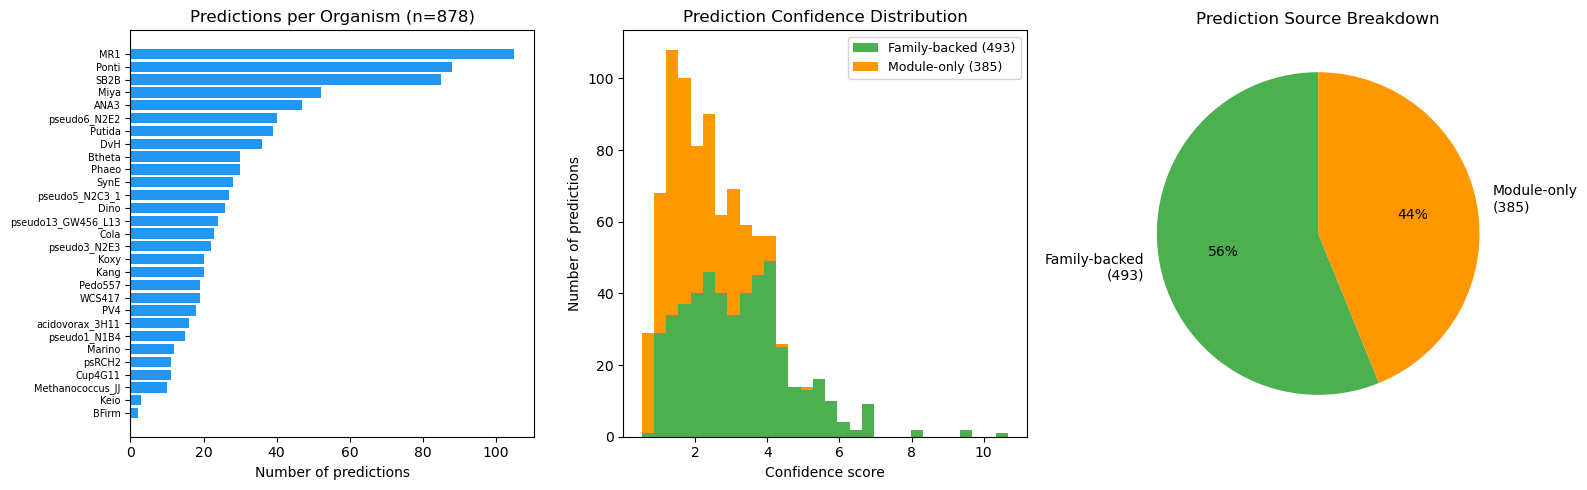

Saved: figures/prediction_summary.png


In [5]:
import matplotlib.pyplot as plt

FIG_DIR = Path('../figures')

fig, axes = plt.subplots(1, 3, figsize=(16, 5))

# Left: predictions per organism
ax = axes[0]
org_counts = combined.groupby('orgId').size().sort_values(ascending=True)
colors_pred = ['#4CAF50' if combined[combined['orgId']==o]['prediction_source'].mode().values[0]=='family'
               else '#2196F3' for o in org_counts.index]
ax.barh(range(len(org_counts)), org_counts.values, color='#2196F3')
ax.set_yticks(range(len(org_counts)))
ax.set_yticklabels(org_counts.index, fontsize=7)
ax.set_xlabel('Number of predictions')
ax.set_title(f'Predictions per Organism (n={len(combined)})')

# Middle: confidence distribution
ax = axes[1]
family_conf = combined[combined['prediction_source'] == 'family']['confidence']
module_conf = combined[combined['prediction_source'] == 'module']['confidence']
ax.hist([family_conf, module_conf], bins=30, stacked=True,
        label=[f'Family-backed ({len(family_conf)})', f'Module-only ({len(module_conf)})'],
        color=['#4CAF50', '#FF9800'])
ax.set_xlabel('Confidence score')
ax.set_ylabel('Number of predictions')
ax.set_title('Prediction Confidence Distribution')
ax.legend(fontsize=9)

# Right: family-backed vs module-only pie
ax = axes[2]
source_counts = combined['prediction_source'].value_counts()
ax.pie(source_counts.values, labels=[f'Family-backed\n({source_counts.get("family", 0)})',
                                      f'Module-only\n({source_counts.get("module", 0)})'],
       colors=['#4CAF50', '#FF9800'], autopct='%1.0f%%', startangle=90)
ax.set_title('Prediction Source Breakdown')

plt.tight_layout()
plt.savefig(FIG_DIR / 'prediction_summary.png', dpi=150, bbox_inches='tight')
plt.show()
print(f"Saved: figures/prediction_summary.png")